<a href="https://colab.research.google.com/github/Ftajedini/Github_Tutorial/blob/main/men__women_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!kaggle competitions download -c dogs-vs-cats

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
#transfer data to /root/.kaggle.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
chmod: cannot access '/root/.kaggle.json': No such file or directory


In [ ]:
#!kaggle competitions download -c dogs-vs-cats

403 - Forbidden - You must accept this competition's rules before you'll be able to download files.


In [ ]:
from google.colab import files
_=files.upload()

Saving kaggle.json to kaggle.json


#Download dataset from Kaggle

In [ ]:
# ravesh dige baraye estefade az dataset
!kaggle datasets download -d saadpd/menwomen-classification

 99% 801M/806M [00:09<00:00, 96.3MB/s]
100% 806M/806M [00:09<00:00, 84.5MB/s]


In [ ]:
#unzip--- -qq bedone neshondadan unzip kon
!unzip -qq menwomen-classification

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, Model, Sequential, optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
#amadesazi dataset
import os
num_men_train = len(os.listdir('traindata/traindata/men'))
num_women_train = len(os.listdir('traindata/traindata/women'))
num_men_test = len(os.listdir('testdata/testdata/men'))
num_women_test = len(os.listdir('testdata/testdata/women'))

print (f'Train: men:{num_men_train}| women:{num_women_train}')
print (f'Train: men:{num_men_test}| women:{num_women_test}')

Train: men:1000| women:1912
Train: men:418| women:915


#Create dataset directories

In [ ]:
#tagheir chideman dataset
import shutil, pathlib

new_base_dir = pathlib.Path("men_vs_women_small")

def make_subset(base_dir, subset_name, start_index, end_index):
    for category in ("men", "women"):
        dir = new_base_dir / subset_name / category
        if not os.path.exists(dir):
            os.makedirs(dir)
        files = os.listdir(os.path.join(base_dir, category))
        fnames = [files[i] for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=os.path.join(base_dir, category, fname),
            dst=os.path.join(dir, fname))


In [ ]:
make_subset("traindata/traindata", "validation", start_index=0, end_index=200)
make_subset("traindata/traindata", "train", start_index=200, end_index=1000)
make_subset("testdata/testdata", "test", start_index=0, end_index=400)

#Create Train/Validation/Test datasets

In [ ]:
#load_dataset
print('Train lodear: ')
train_dataset = image_dataset_from_directory(
    'men_vs_women_small/train',
     image_size = (180, 180),
     batch_size = 32,
     label_mode='binary'
)
print('validation lodear: ')
validation_dataset = image_dataset_from_directory(
    'men_vs_women_small/validation',
    image_size = (180, 180),
    batch_size = 32,
    label_mode='binary'
)
print('Test lodear: ')
test_dataset = image_dataset_from_directory(
    'men_vs_women_small/test',
    image_size = (180, 180),
    batch_size = 32,
    label_mode='binary'
)

Train lodear: 
Found 1600 files belonging to 2 classes.
validation lodear: 
Found 400 files belonging to 2 classes.
Test lodear: 
Found 800 files belonging to 2 classes.


In [ ]:
type(train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

#Visualize some images/labels

data batch shape:  (32, 180, 180, 3)
data batch shape:  (32, 1)


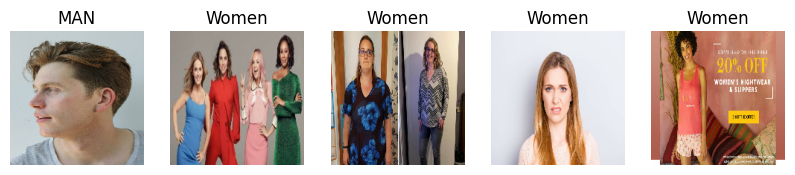

In [ ]:
# Get one batch (containing 32 random images) from training datatset
# you will get different set of images on each run of this cell

for data_batch, label_batch in train_dataset:
    print('data batch shape: ',data_batch.shape)
    print('data batch shape: ',label_batch.shape)
    #print (label_batch)
    #show five random examples of the loaded batch
    fig, axes = plt.subplots(1, 5, figsize=(10,3))
    for i, ax in enumerate(axes):
        ax.imshow(data_batch[i].numpy().astype('uint8'))
        ax.set_axis_off()
        ax.set_title('MAN' if label_batch[i].numpy()==0 else 'Women')
    break
plt.show()

#model Design

In [ ]:
conv_base = VGG16(weights= 'imagenet', include_top=False, input_shape= (180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

##Calculate features from images

In [ ]:
import numpy as np
from tensorflow import keras
from tqdm import tqdm

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in tqdm(dataset):
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

100%|██████████| 25/25 [03:21<00:00,  8.08s/it]


In [ ]:
train_features.shape

(1600, 5, 5, 512)

Classification model

In [ ]:
#main_model
inputs =layers.Input(shape=(5, 5 ,512))
x = layers.GlobalAveragePooling2D()(inputs)
x = layers.Dense(256, activation= 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 131585 (514.00 KB)
Trainable params: 131585 (514.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

Train classification model with feature data

In [ ]:
model.compile(loss ='binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [ ]:
my_callbacks = [
    callbacks.ModelCheckpoint(
        filepath="convent_transfer_learning.h5",
        save_best_only=True,
        monitoe="val_loss")
]

In [ ]:
#very heavy quary
history1 = model.fit(
    train_features, train_labels,
    epochs =30,
    validation_data =(val_features, val_labels),
    callbacks = my_callbacks,
    batch_size = 32
    )

Epoch 1/30
50/50 [==============================] - 2s 14ms/step - loss: 1.2902 - accuracy: 0.7188 - val_loss: 0.6515 - val_accuracy: 0.8300
Epoch 2/30
24/50 [=============>................] - ETA: 0s - loss: 0.5346 - accuracy: 0.8698

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 0s 6ms/step - loss: 0.4789 - accuracy: 0.8681 - val_loss: 0.4677 - val_accuracy: 0.8450
Epoch 3/30
50/50 [==============================] - 0s 7ms/step - loss: 0.3331 - accuracy: 0.8913 - val_loss: 0.4640 - val_accuracy: 0.8300
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.2537 - accuracy: 0.9087 - val_loss: 0.4348 - val_accuracy: 0.8275
Epoch 5/30
50/50 [==============================] - 0s 9ms/step - loss: 0.1955 - accuracy: 0.9231 - val_loss: 0.4378 - val_accuracy: 0.8300
Epoch 6/30
50/50 [==============================] - 1s 14ms/step - loss: 0.1468 - accuracy: 0.9425 - val_loss: 0.4164 - val_accuracy: 0.8200
Epoch 7/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1234 - accuracy: 0.9475 - val_loss: 0.3884 - val_accuracy: 0.8450
Epoch 8/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1057 - accuracy: 0.9606 - val_loss: 0.4327 - val_accuracy: 0.8400
Epoch 9/30
50/50 [============

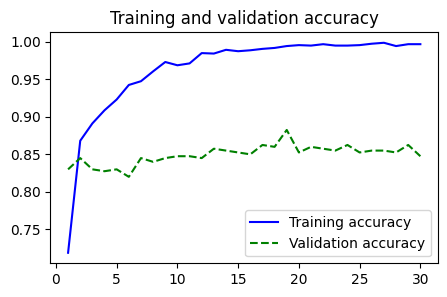

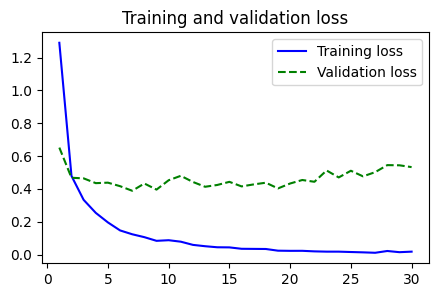

In [ ]:
accuracy = history1.history["accuracy"]
val_accuracy = history1.history["val_accuracy"]
loss = history1.history["loss"]
val_loss = history1.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(5, 3))
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "g--", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(5, 3))
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "g--", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#Transfer Learning + Data Augmentation

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])


In [ ]:
# Freeze the base model
conv_base.trainable = False


#Full model
including Augmentation + VGG16 + classification layers

In [ ]:
inputs = layers.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=inputs, outputs=outputs)
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 180, 180, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0   

#Training Step 1


In [ ]:
model2.compile(loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"])

In [ ]:
my_callbacks2 = [
    callbacks.ModelCheckpoint(
        filepath="convnet_transfer_learning_augmentation.h5",
        save_best_only=True,
        monitor="val_loss")
]

In [ ]:
history2 = model2.fit(train_dataset,
                      epochs=30,
                      validation_data=validation_dataset,
                      callbacks=my_callbacks2)

Epoch 1/30
50/50 [==============================] - 545s 11s/step - loss: 1.2081 - accuracy: 0.6913 - val_loss: 0.5884 - val_accuracy: 0.8175
Epoch 2/30
50/50 [==============================] - 496s 10s/step - loss: 0.6547 - accuracy: 0.7663 - val_loss: 0.5132 - val_accuracy: 0.8325
Epoch 3/30
50/50 [==============================] - 539s 11s/step - loss: 0.4825 - accuracy: 0.8056 - val_loss: 0.4278 - val_accuracy: 0.8300
Epoch 4/30
50/50 [==============================] - 496s 10s/step - loss: 0.3938 - accuracy: 0.8213 - val_loss: 0.4263 - val_accuracy: 0.8500
Epoch 5/30
50/50 [==============================] - 496s 10s/step - loss: 0.3294 - accuracy: 0.8550 - val_loss: 0.4206 - val_accuracy: 0.8550
Epoch 6/30
50/50 [==============================] - 495s 10s/step - loss: 0.3105 - accuracy: 0.8612 - val_loss: 0.4164 - val_accuracy: 0.8575
Epoch 7/30
50/50 [==============================] - 495s 10s/step - loss: 0.3019 - accuracy: 0.8750 - val_loss: 0.4036 - val_accuracy: 0.8600
Epoch 

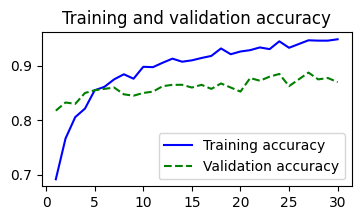

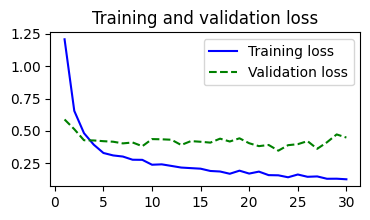

In [ ]:
accuracy = history2.history["accuracy"]
val_accuracy = history2.history["val_accuracy"]
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(4, 2))
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "g--", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(4, 2))
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "g--", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model2.evaluate(test_dataset)

25/25 [==============================] - 204s 8s/step - loss: 1.6660 - accuracy: 0.5550


[1.6660101413726807, 0.5550000071525574]

#Un-freeze the last conv block of VGG16

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 180, 180, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0   

#Training Step 2
Fine-tune the un-freezed layers + classification head

In [ ]:
model2.compile(loss="binary_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"])


In [ ]:
my_callbacks3 = [
    callbacks.ModelCheckpoint(
        filepath="convnet_transfer_learning_augmentation_2.h5",
        save_best_only=True,
        monitor="val_loss")
]


In [ ]:
history3 = model2.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=my_callbacks3)


Epoch 1/25
50/50 [==============================] - 629s 13s/step - loss: 1.2823 - accuracy: 0.5181 - val_loss: 0.8451 - val_accuracy: 0.5600
Epoch 2/25
50/50 [==============================] - 588s 12s/step - loss: 0.7749 - accuracy: 0.5769 - val_loss: 0.6859 - val_accuracy: 0.6300
Epoch 3/25
50/50 [==============================] - 627s 13s/step - loss: 0.6754 - accuracy: 0.6150 - val_loss: 0.5967 - val_accuracy: 0.6800
Epoch 4/25
50/50 [==============================] - 617s 12s/step - loss: 0.5977 - accuracy: 0.6712 - val_loss: 0.5186 - val_accuracy: 0.7300
Epoch 5/25
50/50 [==============================] - 574s 11s/step - loss: 0.5235 - accuracy: 0.7212 - val_loss: 0.4451 - val_accuracy: 0.7700
Epoch 6/25
50/50 [==============================] - ETA: 0s - loss: 0.4859 - accuracy: 0.7556

#History of both steps together

In [ ]:
ccuracy2 = history3.history["accuracy"]
val_accuracy2 = history3.history["val_accuracy"]
loss2 = history3.history["loss"]
val_loss2 = history3.history["val_loss"]

accuracy.extend(accuracy2)
val_accuracy.extend(val_accuracy2)
loss.extend(loss2)
val_loss.extend(val_loss2)

plt.figure(figsize=(4, 2))
plt.plot(accuracy, "b", label="Training accuracy")
plt.plot(val_accuracy, "g--", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(4, 2))
plt.plot(loss, "b", label="Training loss")
plt.plot(val_loss, "g--", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#Final Evaluation

In [ ]:
model2_best = load_model('convnet_transfer_learning_augmentation_2.h5')
model2_best.evaluate(test_dataset)